## Importation des données

In [1]:
import pandas
import numpy as np

In [2]:
raw = pandas.read_excel('filtered_data.xlsx')

In [3]:
raw.columns

Index(['Last Name', 'First Name', 'Position', 'GP', 'G', 'A', 'A1', 'PTS',
       '+/-', 'IPP%', 'TOI/GP', 'iCF', 'iFF', 'iSF', 'iSCF', 'iHDCF', 'iRush',
       'iReb', 'Pass', 'ZS%', 'iGVA', 'iTKA', 'iBLK', 'S.Bkhd', 'S.Dflct',
       'S.Slap', 'S.Snap', 'S.Tip', 'S.Wrap', 'S.Wrst', 'CF', 'CA', 'FF', 'FA',
       'SF', 'SA', 'Ht', 'Wt', 'Age', 'PIM'],
      dtype='object')

In [4]:
player_names = raw['First Name'].values + ' ' + raw['Last Name'].values
raw = raw.drop(columns=['First Name', 'Last Name'])

In [5]:
targets_goals = raw['G'].values.reshape(-1,1).astype(dtype = 'float32')
targets_assists = raw['A'].values.reshape(-1,1).astype(dtype = 'float32')
targets_primary_assists = raw['A1'].values.reshape(-1,1).astype(dtype = 'float32')
targets_points = raw['PTS'].values.reshape(-1,1).astype(dtype = 'float32')
targets_plusminus = raw['+/-'].values.reshape(-1,1).astype(dtype = 'float32')
raw = raw.drop(columns = ['G', 'A', 'A1','PTS', '+/-'])

In [6]:
for i,position in enumerate(raw['Position']):
    if position in ['C/RW', 'LW/C', 'LW/RW', 'RW/C', 'LW', 'RW']:
        raw['Position'][i] = 'W'
one_hot_position = pandas.get_dummies(raw['Position'])
raw = raw.drop(columns = ['Position'])

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
def shuffle_data(*sets):
    rng_state = np.random.get_state()
    for set in sets:
        np.random.set_state(rng_state)
        np.random.shuffle(set)

In [8]:
data = np.concatenate((one_hot_position, raw.values), axis=1).astype(dtype = 'float32')
shuffle_data(player_names, targets_goals, targets_assists, targets_primary_assists, targets_plusminus, targets_points, data)

In [9]:
train_size = int(data.shape[0] * 0.70)
valid_size = int(data.shape[0] * 0.10)
split = np.array([train_size+valid_size])

In [18]:
#Separate training and test sets
training_player_names, test_player_names = np.split(player_names, split)
training_targets_goals, test_targets_goals = np.split(targets_goals, split)
training_targets_assists, test_targets_assists = np.split(targets_assists, split)
training_targets_primary_assists, test_targets_primary_assists = np.split(targets_primary_assists, split)
training_targets_plusminus, test_targets_plusminus = np.split(targets_plusminus, split)
training_targets_points, test_targets_points = np.split(targets_points, split)
training_data, test_data = np.split(data, split)

## MLP

In [11]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import time

In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(35, 200)
        self.fc2 = nn.Linear(200,1)
        self.bn1 = nn.BatchNorm1d(num_features=35)
        self.bn2 = nn.BatchNorm1d(num_features=200)
#        self.bn3 = nn.BatchNorm1d(num_features=100)
#        self.fc3 = nn.Linear(100, 1)
#        self.fc4 = nn.Linear(50, 20)
#        self.fc5 = nn.Linear(20, 1)
    
    def forward(self, x):
        x = self.fc1(self.bn1(x))
        x = self.fc2(self.bn2(x))
#        x = self.fc3(self.bn3(x))
#         x = self.fc4(x)
#         x = self.fc5(x)
        return x

In [13]:
class hockey_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        
    def __getitem__(self, index):
        d = self.data[index]
        if self.transforms is not None:
            d = self.transforms(d)
        return (d, self.labels[index])
    
    def __len__(self):
        return self.labels.shape[0]

In [14]:
def train(train_data, train_labels, test_data, test_labels, nepochs):
    
    trainset = hockey_dataset(train_data[:train_size], train_labels[:train_size])
    validset = hockey_dataset(train_data[train_size:], train_labels[train_size:])
    testset = hockey_dataset(test_data, test_labels)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle = True)
    validloader = torch.utils.data.DataLoader(validset, batch_size=100, shuffle = False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle = False)
    
    network = Network().to(device)
    criterion = nn.MSELoss()
    lr = 0.002
    optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.01, momentum = 0)
    
    loss_train, loss_valid = [],[]
    
    for epoch in range(nepochs):
        if (epoch > 0) and (epoch%100 == 0):
            lr = lr*0.5
            optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.01, momentum = 0)
        current_loss_train, current_loss_valid = 0,0
        network.train()
        for data in trainloader:
            inputs, label = data
            optimizer.zero_grad()
            output = network(inputs.to(device))
            loss = criterion(output, label.to(device))
            loss.backward()
            optimizer.step()
            current_loss_train += loss.item()/train_size
        loss_train.append(current_loss_train)
        
        with torch.no_grad():
            network.eval()
            for data in validloader:
                inputs, label = data
                output = network(inputs.to(device))
                loss = criterion(output, label.to(device))
                current_loss_valid += loss.item()/valid_size
        loss_valid.append(current_loss_valid)
        if epoch%100 == 0:
            print('Epoch: {}'.format(epoch))
            print('Train loss: {0:.4f}'.format(loss_train[-1]))
            print('Valid loss: {0:.4f}'.format(loss_valid[-1]))
    print('Finished Training')
    
    print('Mean loss of last 50 iterations(test): ',np.array(loss_train[-50:]).mean())
    print('Mean loss of last 50 iterations(valid): ',np.array(loss_valid[-50:]).mean())

    with torch.no_grad():
        loss = 0
        for data in testloader:
            inputs, label = data
            predictions = network(inputs.to(device))
            loss += criterion(predictions, label.to(device))/len(testset)
        print('Test loss: ', loss.item())
    
    return loss_train, loss_valid, predictions

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

In [16]:
# nepochs = 801
# targets = [training_targets_goal, test_targets_goals]
# t1 = time.time()
# loss_train, loss_valid, predictions = train(training_data, targets[0], test_data, targets[1], nepochs)
# print("Temps d'entrainement : {}".format(time.time()-t1))

# fig,ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
# ax1, ax2 = ax.flatten()
# ax1.plot(range(1,nepochs), loss_train[1:], 'k,-', label='Train')
# ax1.plot(range(1,nepochs), loss_valid[1:], 'r,-', label='Valid')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Average Loss')
# ax1.legend()

# ax2.plot(range(5,nepochs), loss_train[5:], 'k,-', label='Train')
# ax2.plot(range(5,nepochs), loss_valid[5:], 'r,-', label='Valid')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Average Loss')
# ax2.legend()
# plt.show()
# plt.close()

Epoch: 0
Train loss: 1.2660
Valid loss: 1.2885
Epoch: 100
Train loss: 0.1180
Valid loss: 0.1553
Epoch: 200
Train loss: 0.1163
Valid loss: 0.1462
Epoch: 300
Train loss: 0.1434
Valid loss: 0.1433
Epoch: 400
Train loss: 0.1276
Valid loss: 0.1411
Epoch: 500
Train loss: 0.1117
Valid loss: 0.1446
Epoch: 600
Train loss: 0.1118
Valid loss: 0.1425
Epoch: 700
Train loss: 0.1139
Valid loss: 0.1446
Epoch: 800
Train loss: 0.1096
Valid loss: 0.1399
Finished Training
Mean loss of last 50 iterations(test):  0.12262412424837604
Mean loss of last 50 iterations(valid):  0.14208949571245172
Test loss:  0.049291953444480896
Temps d'entrainement : 31.05575156211853
Epoch: 0
Train loss: 3.3087
Valid loss: 1.9003
Epoch: 100
Train loss: 0.2144
Valid loss: 0.1673
Epoch: 200
Train loss: 0.2542
Valid loss: 0.1643
Epoch: 300
Train loss: 0.2712
Valid loss: 0.1600
Epoch: 400
Train loss: 0.2149
Valid loss: 0.1609
Epoch: 500
Train loss: 0.2148
Valid loss: 0.1568
Epoch: 600
Train loss: 0.2096
Valid loss: 0.1604
Epoch: 

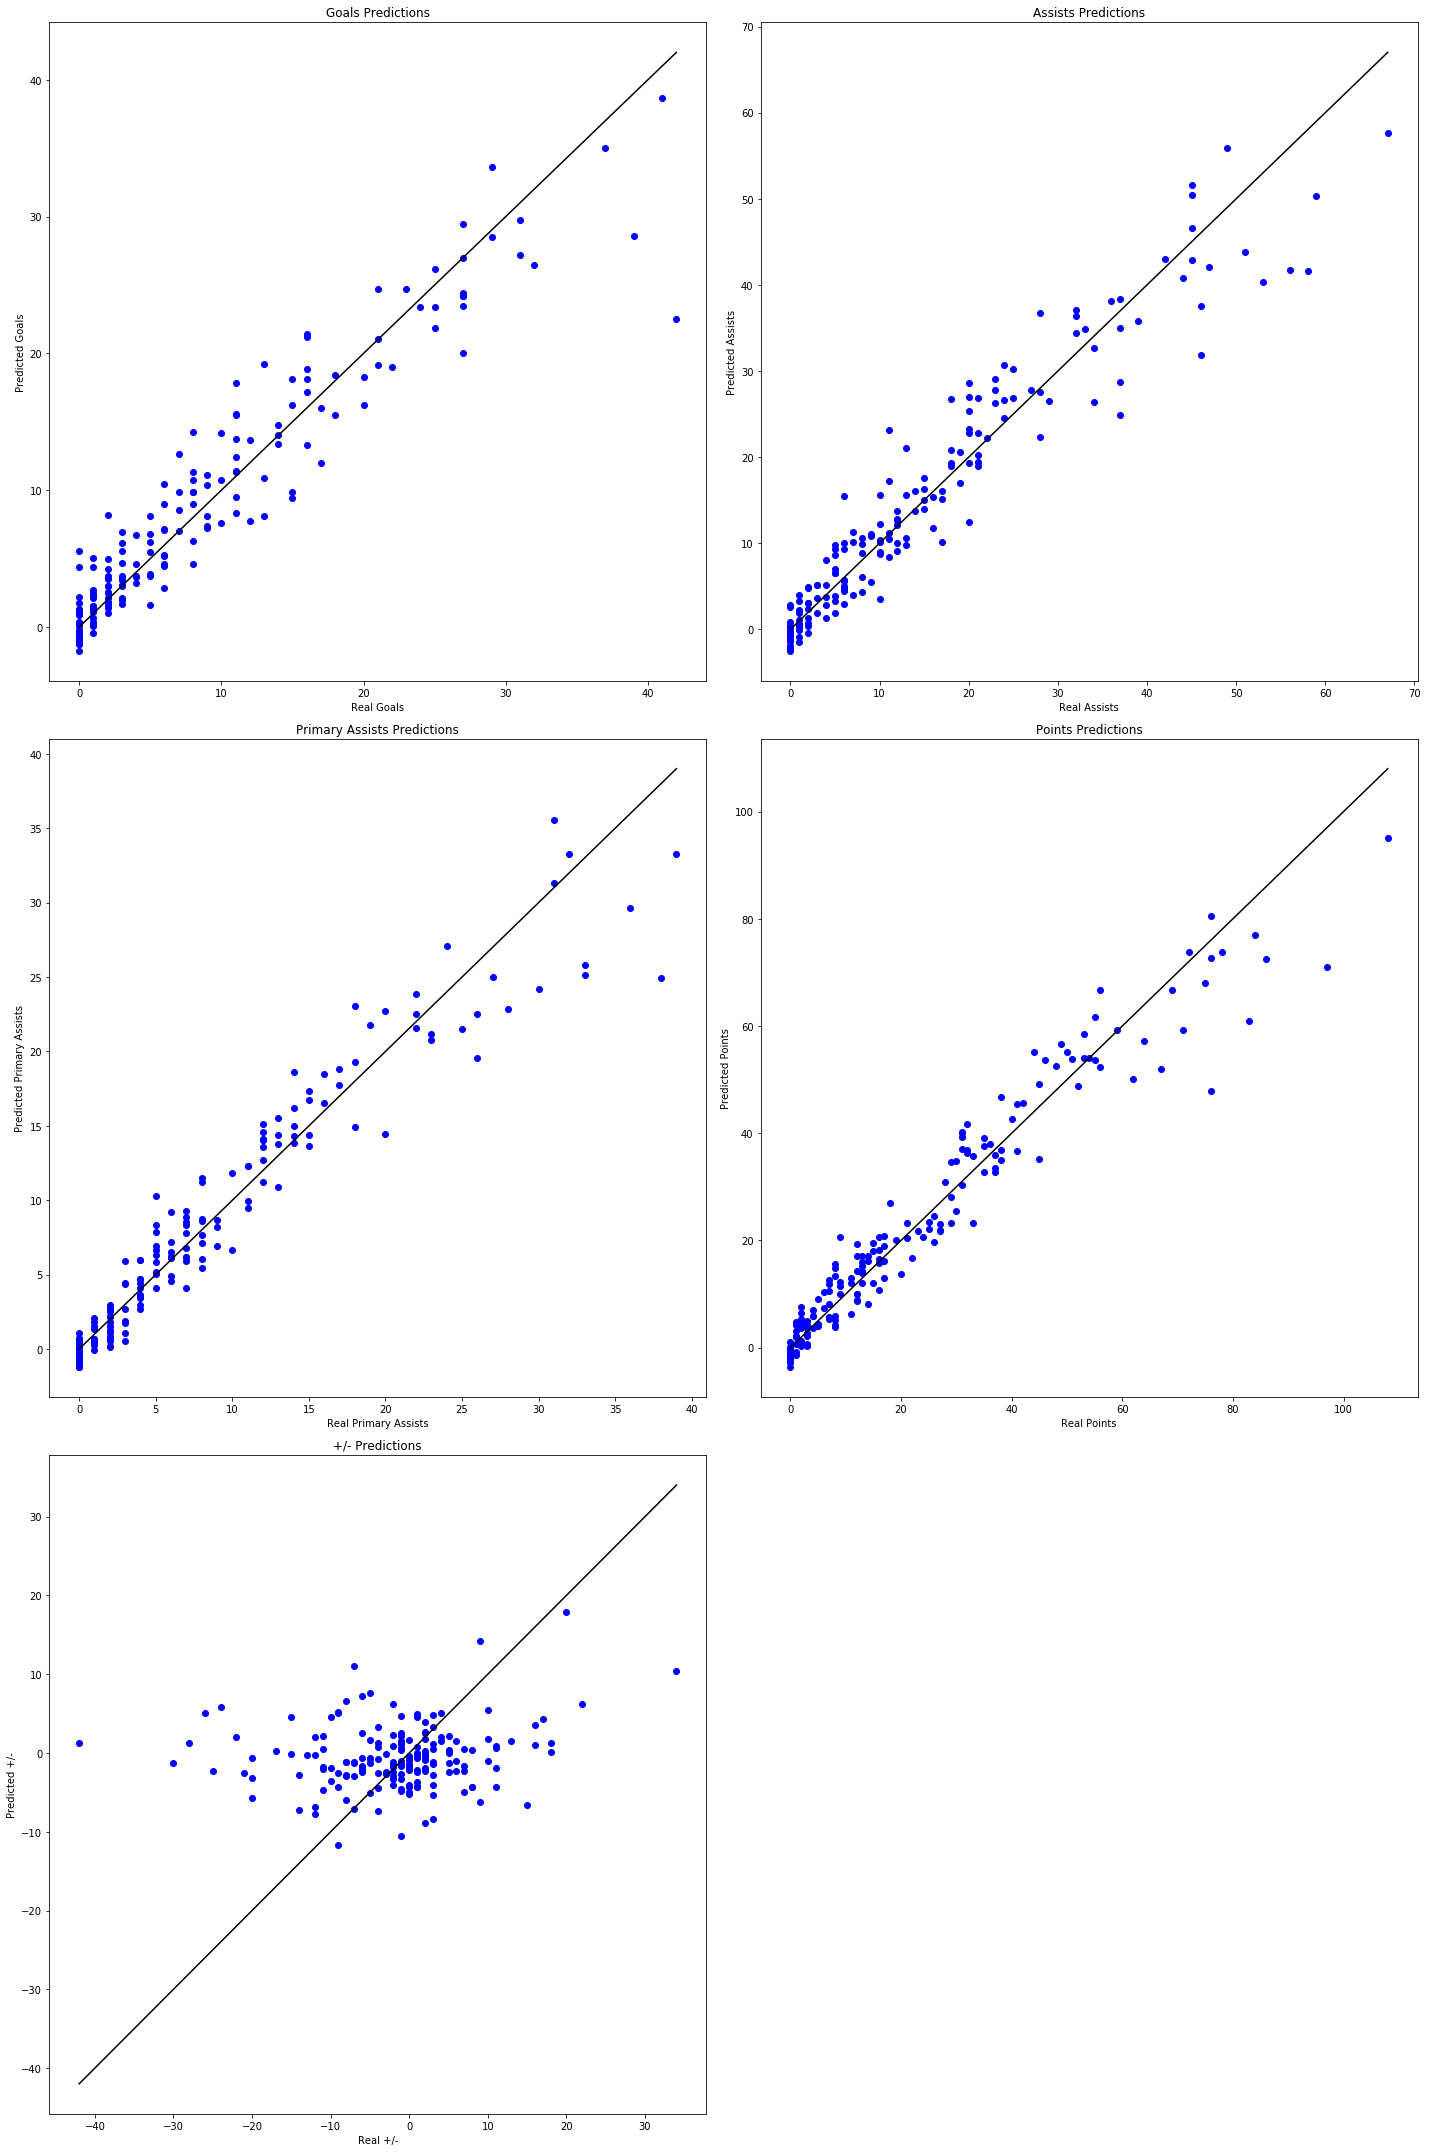

In [65]:
nepochs = 801
predictions_totales = []
for targets in [[training_targets_goals, test_targets_goals],
                [training_targets_assists, test_targets_assists],
                [training_targets_primary_assists, test_targets_primary_assists],
                [training_targets_points, test_targets_points],
                [training_targets_plusminus, test_targets_plusminus]]:
    t1 = time.time()
    loss_train, loss_valid, predictions = train(training_data, targets[0], test_data, targets[1], nepochs)
    print("Temps d'entrainement : {}".format(time.time()-t1))
    predictions_totales.append(predictions)
    

fig,ax = plt.subplots(nrows=3, ncols=2, figsize = (20,30))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.scatter(test_targets_goals, predictions_totales[0], c = 'b')
ax1.plot([0,np.max(test_targets_goals)],[0,np.max(test_targets_goals)], 'k')
ax1.set_xlabel('Real Goals')
ax1.set_ylabel('Predicted Goals')
ax1.set_title('Goals Predictions')

ax2.scatter(test_targets_assists, predictions_totales[1], c = 'b')
ax2.plot([0,np.max(test_targets_assists)],[0,np.max(test_targets_assists)], 'k')
ax2.set_xlabel('Real Assists')
ax2.set_ylabel('Predicted Assists')
ax2.set_title('Assists Predictions')

ax3.scatter(test_targets_primary_assists, predictions_totales[2], c = 'b')
ax3.plot([0,np.max(test_targets_primary_assists)],[0,np.max(test_targets_primary_assists)], 'k')
ax3.set_xlabel('Real Primary Assists')
ax3.set_ylabel('Predicted Primary Assists')
ax3.set_title('Primary Assists Predictions')

ax4.scatter(test_targets_points, predictions_totales[3], c = 'b')
ax4.plot([0,np.max(test_targets_points)],[0,np.max(test_targets_points)], 'k')
ax4.set_xlabel('Real Points')
ax4.set_ylabel('Predicted Points')
ax4.set_title('Points Predictions')

ax5.scatter(test_targets_plusminus, predictions_totales[4], c = 'b')
ax5.plot([np.min(test_targets_plusminus),np.max(test_targets_plusminus)],[np.min(test_targets_plusminus),np.max(test_targets_plusminus)], 'k')
ax5.set_xlabel('Real +/-')
ax5.set_ylabel('Predicted +/-')
ax5.set_title('+/- Predictions')

ax6.axis('off')

fig.tight_layout()
plt.savefig('predictions.png')

In [53]:
pred_goals = predictions_totales[0].cpu().numpy()
pred_assists = predictions_totales[1].cpu().numpy()
pred_primary_assists = predictions_totales[2].cpu().numpy()
pred_points = predictions_totales[3].cpu().numpy()
pred_plusminus = predictions_totales[4].cpu().numpy()

In [54]:
test_player_names[np.argmin(test_targets_plusminus)]

'Nick Leddy'

In [55]:
print(test_targets_points[0].item())
print(pred_points[0])

16.0
[11.129599]


In [58]:
choice = np.where(test_targets_goals>20)[0]
np.mean(np.abs((test_targets_goals[choice]-pred_goals[choice])/test_targets_goals[choice]))

0.12724337

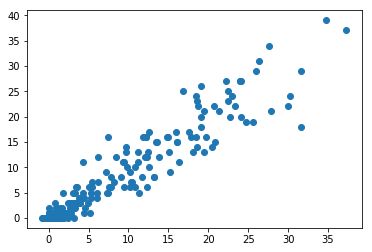

In [65]:
fig, ax = plt.subplots()
ax.scatter(predictions, test_targets_goals)

In [87]:
print(test_player_names[np.where(predictions.cpu().numpy()>30)[0]])
print(test_targets_goals[np.where(predictions.cpu().numpy()>30)[0]])

['Nikita Kucherov' 'Tyler Toffoli' 'Evander Kane' 'Brandon Saad'
 'John Tavares']
[[39.]
 [24.]
 [29.]
 [18.]
 [37.]]
